# Italian Airports Network - Performance Analysis since 2000  
  
  <br/><br/>

![](images/00_cover.gif?raw=true)

## 01. Data Collection and Preparation  
  
  <br/><br/>

This is a personal project that aims to analyze the performance of Italian airports in terms of key operational metrics: aircraft movements, passenger traffic, and freight throughput.  
By examining historical data (starting from the year 2000) and identifying trends, my goal is to gain insights into the efficiency, capacity, and potential areas for improvement of different airports.  
  
  The primary data sources for this analysis is [Assaeroporti](https://assaeroporti.com/), the association of Italian airport operators, which collect historical records on aircraft movements, passenger numbers, and freight tonnage.  
  
  After the data collection, I collated and cleaned the different datasets before enriching them with the IATA code and the geographic area for each airport.  
Before performing EDA, there are other potential features that can be added to the dataset:
- geographic coordinates
- potential catchment area (30 minutes, 60 minutes distance)
- distance from closest motorway exit
- distance from closest railway station
- dimensional class
  
  <br/><br/>
  

## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import warnings
import glob
import os

from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import re

from time import time, sleep

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

In [4]:
# run to avoid warnings
warnings.filterwarnings('ignore')

## Data Extraction

The first step is to collect all available monthly datasets from the Assaeroporti website.

In [5]:
options = webdriver.ChromeOptions() ;
prefs = {"download.default_directory" : "D:\Federico\02_Projects\01_Data_Science\05_Italian_Airports\datasets"};
options.add_experimental_option("prefs",prefs);

In [6]:
URL_example = "https://assaeroporti.com/wp-content/plugins/multipage_xls_reader/excel_file/2019_12.xls"

In [15]:
# download old monthly datasets
dr = webdriver.Chrome()
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for year in range(2000, 2024):

    for month in months:
            
        URL = f'https://assaeroporti.com/wp-content/plugins/multipage_xls_reader/excel_file/{year}_{month}.xls'
        
        dr.get(URL)
        
        sleep(2)
        
dr.quit()

All monthly datasets are downloaded from the website, except for June 2001 which is not available.  
I collected almost 300 Excel files, each one including 8 worksheets for the main operational metrics.  
After checking some Excel files from different years, I can define exactly which column to extract and in which worksheet: fortunately these fields are consistent across the entire file collection, so I can automate the process.  
  
  <br/><br/>

In [7]:
# define the Excel worksheets to access
sheets_list = [5, 6, 7]              # Movimenti [mese], Passeggeri [mese], Cargo [mese]

# define the columns to extract for each worksheet
columns_list_00 = [1, 2, 4, 6, 10]   # B, C, E, G, K
columns_list_01 = [2, 4, 6, 8, 12]   # C, E, G, I, M
columns_list_02 = [2, 4, 8]          # C, E, I

# These columns numbers are working for all files from January 2000

In [8]:
excel_try = 'datasets/original/2000_01.xls'

In [9]:
# create three partial dataframes from each worksheet: movements, passengers, freight
df_MOV = pd.read_excel(excel_try, sheet_name=sheets_list[0], usecols=columns_list_00)
df_PAX = pd.read_excel(excel_try, sheet_name=sheets_list[1], usecols=columns_list_01)
df_FRE = pd.read_excel(excel_try, sheet_name=sheets_list[2], usecols=columns_list_02)

In [10]:
# display the movements dataframe
df_MOV

,Movimenti del mese,Gennaio 2000 (su base1999),Unnamed: 4,Unnamed: 6,Unnamed: 10
0,Aeroporto,Nazionali,Internazionali,di cui C. Europea,Aviazione Generale
1,Alghero,515,25,0,0
2,Ancona,476,346,182,574
3,Bari,1437,77,0,355
4,Bergamo,770,2302,1543,216
5,Bologna,1379,3108,2576,239
6,Bolzano,98,128,128,0
7,Brescia,152,34,32,70
8,Brindisi,502,22,0,107
9,Cagliari,1691,146,103,183


In [11]:
# display the passengers dataframe
df_PAX

,Gennaio 2000 (su base1999),Unnamed: 4,Unnamed: 6,Unnamed: 8,Unnamed: 12
0,Nazionali,Internazionali,di cui C. Europea,Transito,Aviazione Generale
1,30634,799,0,0,0
2,18183,12098,7056,61,656
3,82936,1217,0,68,110
4,38403,48697,25666,653,189
5,67923,150338,120214,5424,307
6,2031,1298,1298,0,0
7,2584,3411,3234,0,93
8,34360,12,0,73,20
9,122856,4968,2173,4251,97


In [12]:
# display the freight dataframe
df_FRE

,Gennaio 2000 (su base1999),Unnamed: 4,Unnamed: 8
0,Merci Avio,Merci Superficie,Posta
1,59,0,74
2,232,2,68
3,168,0,193
4,7139,80,1
5,945,422,255
6,0,0,0
7,0,0,0
8,17,0,5
9,235,0,182


In [13]:
# merge the three dataframes
df_try = pd.concat([df_MOV, df_PAX, df_FRE], axis=1)

In [14]:
# assign column names
df_try.columns = ['Airport', 'MOV - Domestic', 'MOV - International', 'MOV - EU', 'MOV - General Avio',
                  'PAX - Domestic', 'PAX - International', 'PAX - EU', 'PAX - Transit', 'PAX - General Avio',
                  'FRE - Goods Avio', 'FRE - Goods Ground', 'FRE - Mail']

In [15]:
# remove first and last row
df_try = df_try.iloc[1:-1]

In [16]:
# add a date column which includes year and month
df_try['Date']=excel_try
df_try['Date']=df_try['Date'].str.replace('\D', '', regex=True)
df_try['Date']=df_try['Date'].astype(str).str[:4] + '/' + df_try['Date'].astype(str).str[4:]

In [17]:
df_try

,Airport,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail,Date
1,Alghero,515,25,0,0,30634,799,0,0,0,59,0,74,2000/01
2,Ancona,476,346,182,574,18183,12098,7056,61,656,232,2,68,2000/01
3,Bari,1437,77,0,355,82936,1217,0,68,110,168,0,193,2000/01
4,Bergamo,770,2302,1543,216,38403,48697,25666,653,189,7139,80,1,2000/01
5,Bologna,1379,3108,2576,239,67923,150338,120214,5424,307,945,422,255,2000/01
6,Bolzano,98,128,128,0,2031,1298,1298,0,0,0,0,0,2000/01
7,Brescia,152,34,32,70,2584,3411,3234,0,93,0,0,0,2000/01
8,Brindisi,502,22,0,107,34360,12,0,73,20,17,0,5,2000/01
9,Cagliari,1691,146,103,183,122856,4968,2173,4251,97,235,0,182,2000/01
10,Catania,3020,358,234,79,212833,28701,20910,104,38,547,12,364,2000/01


In [18]:
df_try.shape

(35, 14)

In [19]:
# save the test dataframe as CSV
df_try.to_csv('datasets/mod/df_try.csv', encoding='utf-8', index=False)

The test dataframe is correct, I can now automate this process and apply it to all collected data.  
  
  <br/><br/>

#### Write two functions, the first extracting data from specific columns in specific worksheets of an Excel file into a dataframe, the second collating all the resulting dataframes into a single one.

In [169]:
def extract_data(file_path):
    """Extracts data from specific worksheets of an Excel file into a DataFrame.

    Args:
        file_path (str): The path to the Excel file.

    Returns:
        pandas.DataFrame: The extracted data as a DataFrame.
    """

    try:
        df_MOV = pd.read_excel(file_path, sheet_name=sheets_list[0], usecols=columns_list_00)
        df_PAX = pd.read_excel(file_path, sheet_name=sheets_list[1], usecols=columns_list_01)
        df_FRE = pd.read_excel(file_path, sheet_name=sheets_list[2], usecols=columns_list_02)
        df = pd.concat([df_MOV, df_PAX, df_FRE], axis=1)
        df.columns = ['Airport', 'MOV - Domestic', 'MOV - International', 'MOV - EU', 'MOV - General Avio',
                      'PAX - Domestic', 'PAX - International', 'PAX - EU', 'PAX - Transit', 'PAX - General Avio',
                      'FRE - Goods Avio', 'FRE - Goods Ground', 'FRE - Mail']
        df = df.iloc[1:-1]
        df['Date'] = file_path
        df['Date'] = df['Date'].str.replace('\D', '', regex=True)
        df['Date'] = df['Date'].astype(str).str[:4] + '/' + df['Date'].astype(str).str[4:]
        return df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def collate_data(folder_path):
    """Collates data from multiple Excel files into a single DataFrame.

    Args:
        folder_path (str): The path to the folder containing the Excel files.

    Returns:
        pandas.DataFrame: A DataFrame containing the collated data.
    """

    file_paths = glob.glob(f"{folder_path}/*.xls*")
    dataframes = [extract_data(file_path) for file_path in file_paths]
    dataframes = [df for df in dataframes if df is not None]
    collated_df = pd.concat(dataframes, axis=0, ignore_index=True)
    return collated_df



In [170]:
# define the folder path
folder_path = "datasets/original/"

collated_df = collate_data(folder_path)
print(collated_df)

Error processing datasets/original\2000_05.xls: Length mismatch: Expected axis has 11 elements, new values have 13 elements
Error processing datasets/original\2012_09.xls: Length mismatch: Expected axis has 11 elements, new values have 13 elements
          Airport MOV - Domestic MOV - International MOV - EU  \
0         Alghero            515                  25        0   
1          Ancona            476                 346      182   
2            Bari           1437                  77        0   
3         Bergamo            770                2302     1543   
4         Bologna           1379                3108     2576   
...           ...            ...                 ...      ...   
11046  Treviso(^)             58                1610     1275   
11047     Trieste            556                 446      381   
11048  Venezia(^)           1500                6493     4496   
11049   Verona(^)           1116                1920      986   
11050      TOTALI          53519     

In [171]:
collated_df.shape

(11051, 14)

In [172]:
# save the test dataframe as CSV
collated_df.to_csv('datasets/mod/collated_df.csv', encoding='utf-8', index=False)

## Data Preparation

In [20]:
# load the data from CSV for consistency reasons
df_mod = pd.read_csv('datasets/mod/collated_df.csv')

In [21]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11051 entries, 0 to 11050
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Airport              11037 non-null  object 
 1   MOV - Domestic       10976 non-null  object 
 2   MOV - International  10968 non-null  float64
 3   MOV - EU             10932 non-null  float64
 4   MOV - General Avio   10968 non-null  float64
 5   PAX - Domestic       10976 non-null  object 
 6   PAX - International  10968 non-null  float64
 7   PAX - EU             10932 non-null  float64
 8   PAX - Transit        10968 non-null  float64
 9   PAX - General Avio   10968 non-null  float64
 10  FRE - Goods Avio     10978 non-null  object 
 11  FRE - Goods Ground   9453 non-null   object 
 12  FRE - Mail           10970 non-null  float64
 13  Date                 11051 non-null  object 
dtypes: float64(8), object(6)
memory usage: 1.2+ MB


In [22]:
# check for missing values
df_mod.isnull().sum()

Airport                  14
MOV - Domestic           75
MOV - International      83
MOV - EU                119
MOV - General Avio       83
PAX - Domestic           75
PAX - International      83
PAX - EU                119
PAX - Transit            83
PAX - General Avio       83
FRE - Goods Avio         73
FRE - Goods Ground     1598
FRE - Mail               81
Date                      0
dtype: int64

In [23]:
# display the unique values of the column
list(df_mod['Airport'].unique())

['Alghero',
 'Ancona',
 'Bari',
 'Bergamo',
 'Bologna',
 'Bolzano',
 'Brescia',
 'Brindisi',
 'Cagliari',
 'Catania',
 'Crotone',
 'Cuneo',
 'Firenze',
 'Foggia',
 "Forli'",
 'Genova',
 'Lamezia T.',
 'Milano LIN',
 'Milano MXP',
 'Napoli',
 'Olbia',
 'Palermo',
 'Parma',
 'Perugia',
 'Pescara',
 'Pisa',
 'Reggio Cal.',
 'Rimini',
 'Roma CIA',
 'Roma FCO',
 'Ronchi dei L.',
 'Torino',
 'Treviso',
 'Venezia',
 'Verona',
 'Trapani',
 'Siena',
 'Trieste - Ronchi dei L.',
 'Forlì',
 'Grosseto',
 'Lamezia Terme',
 'Milano Linate',
 'Milano Malpensa',
 'Reggio Calabria',
 'Roma Ciampino',
 'Roma Fiumicino',
 'Trieste - Ronchi dei Legionari',
 'Comiso',
 'Trieste',
 'Milano Malpensa (*)',
 '(*) Inclusi movimenti Bergamo - si veda nota di commento',
 'Roma Ciampino (**)',
 'Roma Fiumicino (**)',
 "(**) Nel periodo Mag-Lug 2015, per ragioni operative, parte del traffico di FCO e' stato  trasferito a CIA",
 "(**) Nel periodo Mag-Lug 2015, per ragioni operative, parte del traffico di FCO  e' stat

In [24]:
# display the number of unique values of the column
len(list(df_mod['Airport'].unique()))

101

The airport name column contains several notes that are not relevant to our analysis, and the same airport is referred to by slightly different names throughout the dataset.  
After further research it appears that notes can be deleted with the associated line being blank, and airport names need to be corrected to remove duplicates and ensure consistency.  
  
  
  <br/><br/>

In [25]:
# create a dictionary containing the correct airport names
airports = {
'Alghero' : 'Alghero',
'Ancona' : 'Ancona',
'Bari' : 'Bari',
'Bergamo' : 'Bergamo',
'Bologna' : 'Bologna',
'Bolzano' : 'Bolzano',
'Brescia' : 'Brescia',
'Brindisi' : 'Brindisi',
'Cagliari' : 'Cagliari',
'Catania' : 'Catania',
'Crotone' : 'Crotone',
'Cuneo' : 'Cuneo',
'Firenze' : 'Firenze',
'Foggia' : 'Foggia',
"Forli'" : 'Forlì',
'Genova' : 'Genova',
'Lamezia T.' : 'Lamezia Terme',
'Milano LIN' : 'Milano Linate',
'Milano MXP' : 'Milano Malpensa',
'Napoli' : 'Napoli',
'Olbia' : 'Olbia',
'Palermo' : 'Palermo',
'Parma' : 'Parma',
'Perugia' : 'Perugia',
'Pescara' : 'Pescara',
'Pisa' : 'Pisa',
'Reggio Cal.' : 'Reggio Calabria',
'Rimini' : 'Rimini',
'Roma CIA' : 'Roma Ciampino',
'Roma FCO' : 'Roma Fiumicino',
'Ronchi dei L.' : 'Trieste',
'Torino' : 'Torino',
'Treviso' : 'Treviso',
'Venezia' : 'Venezia',
'Verona' : 'Verona',
'Trapani' : 'Trapani',
'Siena' : 'Siena',
'Trieste - Ronchi dei L.' : 'Trieste',
'Forlì' : 'Forlì',
'Grosseto' : 'Grosseto',
'Lamezia Terme' : 'Lamezia Terme',
'Milano Linate' : 'Milano Linate',
'Milano Malpensa' : 'Milano Malpensa',
'Reggio Calabria' : 'Reggio Calabria',
'Roma Ciampino' : 'Roma Ciampino',
'Roma Fiumicino' : 'Roma Fiumicino',
'Trieste - Ronchi dei Legionari' : 'Trieste',
'Comiso' : 'Comiso',
'Trieste' : 'Trieste',
'Milano Malpensa (*)' : 'Milano Malpensa',
'(*) Inclusi movimenti Bergamo - si veda nota di commento' : '*NOTE*',
'Roma Ciampino (**)' : 'Roma Ciampino',
'Roma Fiumicino (**)' : 'Roma Fiumicino',
"(**) Nel periodo Mag-Lug 2015, per ragioni operative, parte del traffico di FCO e' stato  trasferito a CIA" : '*NOTE*',
"(**) Nel periodo Mag-Lug 2015, per ragioni operative, parte del traffico di FCO  e' stato  trasferito a CIA - si veda nota di commento" : '*NOTE*',
"(**) Nel periodo Mag-Lug 2015, per ragioni operative, parte del traffico di FCO e' stato  trasferito a CIA." : '*NOTE*',
'Lampedusa' : 'Lampedusa',
'Taranto-Grottaglie' : 'Taranto-Grottaglie',
'Treviso (*)' : 'Treviso',
'nan' : 'nan',
'Trapani (*)' : 'Trapani',
"(*) Lo scalo di Trapani  e' stato chiuso dal 6 novembre al 10 dicembre" : '*NOTE*',
"(**) Lo scalo di Treviso e' stato chiuso dal 4 al 18 ottobre, con conseguente trasferimento a Venezia delle attivita' operative" : '*NOTE*',
'Milano Linate (*)' : 'Milano Linate',
"(*) Lo scalo di Milano Linate e' stato chiuso a partire dal 27 luglio, con conseguente trasferimento a Milano Malpensa delle attivita' operative." : '*NOTE*',
"(*) Lo scalo di Milano Linate e' stato chiuso dal 27 luglio al 25 ottobre, con conseguente trasferimento a Milano Malpensa delle attivita' operative." : '*NOTE*',
'Salerno' : 'Salerno',
'Olbia (*)' : 'Olbia',
"(*) Lo scalo di Olbia e' stato chiuso dal 3 febbraio per rifacimento pista" : '*NOTE*',
"(*) Lo scalo di Olbia e' stato chiuso dal 3 febbraio al 13 marzo per rifacimento pista" : '*NOTE*',
"(*) L’aeroporto di Milano Linate e' stato chiuso dal 27 luglio al 27 ottobre 2019 per rifacimento pista e restyling del terminal." : '*NOTE*',
"(*) Lo scalo di Firenze e' chiuso a partire dal 1 febbraio 2021 per lavori di manutenzione." : '*NOTE*',
"(**) Nel 2020, l’aeroporto di Olbia e' stato chiuso dal 3 febbraio al 13 marzo per i lavori di rifacimento e allungamento della pista di volo." : '*NOTE*',
"(*) Lo scalo di Firenze e' stato chiuso a partire dal 1 febbraio 2021 per lavori di manutenzione" : '*NOTE*',
"(**) Nel 2020, l’aeroporto di Olbia e' stato chiuso dal 3 febbraio al 13 marzo per i lavori di rifacimento e allungamento della pista di volo" : '*NOTE*',
'Brindisi (*)' : 'Brindisi',
"(*) Lo scalo di Brindisi e' rimasto chiuso dal 20 aprile per lavori di riqualifica e ammodernamento della pista " : '*NOTE*',
'Grosseto (**)' : 'Grosseto',
"(**) Nel mese di aprile lo scalo di Grosseto e' rimasto chiuso per lavori sulla pista" : '*NOTE*',
"(*) Lo scalo di Brindisi e' rimasto chiuso fino all 11 maggio per lavori di riqualifica e ammodernamento della pista " : '*NOTE*',
"(**) Nel mese di maggio lo scalo di Grosseto e' rimasto chiuso per lavori sulla pista" : '*NOTE*',
"(*) Lo scalo di Firenze e' stato chiuso dal 1 febbraio al 1 aprile 2021 per lavori di manutenzione della pista." : '*NOTE*',
'Brescia (^)' : 'Brescia',
'Roma Ciampino (^)' : 'Roma Ciampino',
'Roma Fiumicino (^)' : 'Roma Fiumicino',
'Treviso (^)' : 'Treviso',
'Venezia (^)' : 'Venezia',
'Verona (^)' : 'Verona',
'Brescia(^)' : 'Brescia',
'Roma Ciampino(^)' : 'Roma Ciampino',
'Roma Fiumicino(^)' : 'Roma Fiumicino',
'Treviso(^)' : 'Treviso',
'Venezia(^)' : 'Venezia',
'Verona(^)' : 'Verona',
'TOTALI' : 'TOTALI',
'Grosseto(*)' : 'Grosseto',
'Trapani(**)' : 'Trapani',
'Bari(^)' : 'Bari',
'Brindisi(^)' : 'Brindisi',
'Foggia(^)' : 'Foggia',
'Taranto-Grottaglie(^)' : 'Taranto-Grottaglie'}

In [26]:
# replace the airport names using the dictionary
df_mod.replace({'Airport': airports}, inplace=True)

In [27]:
list(df_mod['Airport'].unique())

['Alghero',
 'Ancona',
 'Bari',
 'Bergamo',
 'Bologna',
 'Bolzano',
 'Brescia',
 'Brindisi',
 'Cagliari',
 'Catania',
 'Crotone',
 'Cuneo',
 'Firenze',
 'Foggia',
 'Forlì',
 'Genova',
 'Lamezia Terme',
 'Milano Linate',
 'Milano Malpensa',
 'Napoli',
 'Olbia',
 'Palermo',
 'Parma',
 'Perugia',
 'Pescara',
 'Pisa',
 'Reggio Calabria',
 'Rimini',
 'Roma Ciampino',
 'Roma Fiumicino',
 'Trieste',
 'Torino',
 'Treviso',
 'Venezia',
 'Verona',
 'Trapani',
 'Siena',
 'Grosseto',
 'Comiso',
 '*NOTE*',
 'Lampedusa',
 'Taranto-Grottaglie',
 nan,
 'Salerno',
 'TOTALI']

In [28]:
# check the values in the 'airport' column
df_mod['Airport'].value_counts()

Alghero               293
Reggio Calabria       293
Olbia                 293
Palermo               293
Ancona                293
Perugia               293
Pescara               293
Pisa                  293
Roma Ciampino         293
Milano Malpensa       293
Roma Fiumicino        293
Trieste               293
Torino                293
Treviso               293
Venezia               293
Verona                293
Napoli                293
Parma                 293
Milano Linate         293
Cagliari              293
Bari                  293
Bergamo               293
Bologna               293
Lamezia Terme         293
Brescia               293
Brindisi              293
Bolzano               293
Genova                293
Catania               293
Cuneo                 293
Firenze               293
Foggia                293
Trapani               279
Rimini                269
Crotone               245
Forlì                 202
Grosseto              151
Comiso                116
Siena       

In [29]:
df_mod.drop(df_mod[df_mod['Airport'] == '*NOTE*'].index, inplace=True)
df_mod.drop(df_mod[df_mod['Airport'] == 'TOTALI'].index, inplace=True)

In [30]:
df_mod = df_mod[df_mod['Airport'].notna()]

In [31]:
df_mod.shape

(10997, 14)

In [32]:
# check for missing values
df_mod.isnull().sum()

Airport                   0
MOV - Domestic           42
MOV - International      44
MOV - EU                 80
MOV - General Avio       44
PAX - Domestic           42
PAX - International      44
PAX - EU                 80
PAX - Transit            44
PAX - General Avio       44
FRE - Goods Avio         45
FRE - Goods Ground     1562
FRE - Mail               47
Date                      0
dtype: int64

In [33]:
# check for strings in the 'MOV - domestic' column - which should be numeric - by forcing conversion to numeric
# or NaN using a new column
df_mod['col_num'] = pd.to_numeric(df_mod['MOV - Domestic'], errors='coerce')

In [34]:
# check the original values giving NaN
df_mod.loc[df_mod['MOV - Domestic'].notna()&df_mod['col_num'].isna(), 'MOV - Domestic']

8286    Dati non disponibili
8325    Dati non disponibili
Name: MOV - Domestic, dtype: object

In [35]:
# force conversion to numeric the original column
df_mod['MOV - Domestic'] = pd.to_numeric(df_mod['MOV - Domestic'], errors='coerce')

In [36]:
df_mod

,Airport,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail,Date,col_num
0,Alghero,515.0,25.0,0.0,0.0,30634,799.0,0.0,0.0,0.0,59,0,74.000,2000/01,515.0
1,Ancona,476.0,346.0,182.0,574.0,18183,12098.0,7056.0,61.0,656.0,232,2,68.000,2000/01,476.0
2,Bari,1437.0,77.0,0.0,355.0,82936,1217.0,0.0,68.0,110.0,168,0,193.000,2000/01,1437.0
3,Bergamo,770.0,2302.0,1543.0,216.0,38403,48697.0,25666.0,653.0,189.0,7139,80,1.000,2000/01,770.0
4,Bologna,1379.0,3108.0,2576.0,239.0,67923,150338.0,120214.0,5424.0,307.0,945,422,255.000,2000/01,1379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11045,Trapani,635.0,308.0,270.0,116.0,90896,53226.0,46540.0,125.0,181.0,0,0,0.000,2024/08,635.0
11046,Treviso,58.0,1610.0,1275.0,270.0,8858,286104.0,227946.0,180.0,281.0,0,0,0.000,2024/08,58.0
11047,Trieste,556.0,446.0,381.0,193.0,68278,64413.0,53494.0,24.0,206.0,6.249,0.263,0.000,2024/08,556.0
11048,Venezia,1500.0,6493.0,4496.0,642.0,230856,974277.0,610136.0,1199.0,1379.0,4527.423,564.7301,0.091,2024/08,1500.0


In [37]:
# check for strings in the 'PAX - domestic' column - which should be numeric - by forcing conversion to numeric
# or NaN using a new column
df_mod['col_num'] = pd.to_numeric(df_mod['PAX - Domestic'], errors='coerce')

In [38]:
# check the original values giving NaN
df_mod.loc[df_mod['PAX - Domestic'].notna()&df_mod['col_num'].isna(), 'PAX - Domestic']

8286    Dati non disponibili
8325    Dati non disponibili
Name: PAX - Domestic, dtype: object

In [39]:
# force conversion to numeric the original column
df_mod['PAX - Domestic'] = pd.to_numeric(df_mod['PAX - Domestic'], errors='coerce')

In [40]:
# check for strings in the 'FRE - goods avio' column - which should be numeric - by forcing conversion to numeric
# or NaN using a new column
df_mod['col_num'] = pd.to_numeric(df_mod['FRE - Goods Avio'], errors='coerce')

In [41]:
# check the original values giving NaN
df_mod.loc[df_mod['FRE - Goods Avio'].notna()&df_mod['col_num'].isna(), 'FRE - Goods Avio']

8286    Dati non disponibili
8325    Dati non disponibili
Name: FRE - Goods Avio, dtype: object

In [42]:
# force conversion to numeric the original column
df_mod['FRE - Goods Avio'] = pd.to_numeric(df_mod['FRE - Goods Avio'], errors='coerce')

In [43]:
# check for strings in the 'FRE - goods ground' column - which should be numeric - by forcing conversion to numeric
# or NaN using a new column
df_mod['col_num'] = pd.to_numeric(df_mod['FRE - Goods Ground'], errors='coerce')

In [44]:
# check the original values giving NaN
df_mod.loc[df_mod['FRE - Goods Ground'].notna()&df_mod['col_num'].isna(), 'FRE - Goods Ground']

8339        nd
8417        nd
8456        nd
8495        nd
8535        nd
8575        nd
8615        nd
8655        nd
8695        nd
8735        nd
9207          
9574       n/d
9615       n/d
10186         
Name: FRE - Goods Ground, dtype: object

In [45]:
# force conversion to numeric the original column
df_mod['FRE - Goods Ground'] = pd.to_numeric(df_mod['FRE - Goods Ground'], errors='coerce')

In [46]:
df_mod = df_mod.drop('col_num', axis=1)

In [47]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10997 entries, 0 to 11049
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Airport              10997 non-null  object 
 1   MOV - Domestic       10953 non-null  float64
 2   MOV - International  10953 non-null  float64
 3   MOV - EU             10917 non-null  float64
 4   MOV - General Avio   10953 non-null  float64
 5   PAX - Domestic       10953 non-null  float64
 6   PAX - International  10953 non-null  float64
 7   PAX - EU             10917 non-null  float64
 8   PAX - Transit        10953 non-null  float64
 9   PAX - General Avio   10953 non-null  float64
 10  FRE - Goods Avio     10950 non-null  float64
 11  FRE - Goods Ground   9421 non-null   float64
 12  FRE - Mail           10950 non-null  float64
 13  Date                 10997 non-null  object 
dtypes: float64(12), object(2)
memory usage: 1.3+ MB


In [48]:
# display summary statistics for the numeric columns
df_mod.describe()

,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail
count,10953.000000,10953.000000,10917.000000,10953.000000,1.095300e+04,1.095300e+04,1.091700e+04,10953.000000,10953.000000,10950.000000,9421.000000,10950.000000
mean,1229.287958,1625.129280,1183.102501,424.169634,1.220099e+05,1.805017e+05,1.274338e+05,1595.406115,583.187437,1923.600506,113.545119,158.409187
std,1898.552980,3228.309712,2211.746869,495.380620,1.880422e+05,3.968137e+05,2.543858e+05,4787.106006,1202.532624,7021.970420,325.921252,476.405033
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,185.000000,69.000000,27.000000,123.000000,6.890000e+03,4.000000e+03,4.300000e+02,0.000000,105.000000,0.243500,0.000000,0.000000
50%,582.000000,367.000000,235.000000,276.000000,4.791100e+04,3.313300e+04,2.198600e+04,139.000000,293.000000,34.425500,0.000000,0.000000
75%,1504.000000,1732.000000,1330.000000,527.000000,1.605960e+05,1.647710e+05,1.288250e+05,1003.000000,633.000000,546.996250,35.000000,123.000000
max,14723.000000,22480.000000,15191.000000,4418.000000,1.343545e+06,4.034068e+06,2.362590e+06,51498.000000,35537.000000,85208.042000,9330.000000,5328.000000


In [49]:
# create a dictionary containing the correct airport IATA codes
airport_IATA_codes = {
'Alghero' : 'AHO',
'Ancona' : 'AOI',
'Bari' : 'BRI',
'Bergamo' : 'BGY',
'Bologna' : 'BLQ',
'Bolzano' : 'BZO',
'Brescia' : 'VBS',
'Brindisi' : 'BDS',
'Cagliari' : 'CAG',
'Catania' : 'CTA',
'Comiso' : 'CIY',
'Crotone' : 'CRV',
'Cuneo' : 'CUF',
'Firenze' : 'FLR',
'Foggia' : 'FOG',
'Forlì' : 'FRL',
'Genova' : 'GOA',
'Grosseto' : 'GRS',
'Lamezia Terme' : 'SUF',
'Lampedusa' : 'LMP',
'Milano Linate' : 'LIN',
'Milano Malpensa' : 'MXP',
'Napoli' : 'NAP',
'Olbia' : 'OLB',
'Palermo' : 'PMO',
'Parma' : 'PMF',
'Perugia' : 'PEG',
'Pescara' : 'PSR',
'Pisa' : 'PSA',
'Reggio Calabria' : 'REG',
'Rimini' : 'RMI',
'Roma Ciampino' : 'CIA',
'Roma Fiumicino' : 'FCO',
'Salerno' : 'QSR',
'Siena' : 'SAY',
'Taranto-Grottaglie' : 'TAR',
'Torino' : 'TRN',
'Trapani' : 'TPS',
'Treviso' : 'TSF',
'Trieste' : 'TRS',
'Venezia' : 'VCE',
'Verona' : 'VRN'}

In [50]:
# add a new column for airport code mapping the dictionary
df_mod['Code'] = df_mod['Airport'].map(airport_IATA_codes)

In [51]:
# create a dictionary containing the geographic region for each airport
airport_geo_area = {
'Alghero' : 'Islands',
'Ancona' : 'Central-East',
'Bari' : 'South',
'Bergamo' : 'North-West',
'Bologna' : 'North-East',
'Bolzano' : 'North-East',
'Brescia' : 'North-West',
'Brindisi' : 'South',
'Cagliari' : 'Islands',
'Catania' : 'Islands',
'Comiso' : 'Islands',
'Crotone' : 'South',
'Cuneo' : 'North-West',
'Firenze' : 'Central-West',
'Foggia' : 'South',
'Forlì' : 'Central-East',
'Genova' : 'North-West',
'Grosseto' : 'Central-West',
'Lamezia Terme' : 'South',
'Lampedusa' : 'Islands',
'Milano Linate' : 'North-West',
'Milano Malpensa' : 'North-West',
'Napoli' : 'South',
'Olbia' : 'Islands',
'Palermo' : 'Islands',
'Parma' : 'North-East',
'Perugia' : 'Central-East',
'Pescara' : 'Central-East',
'Pisa' : 'Central-West',
'Reggio Calabria' : 'South',
'Rimini' : 'Central-East',
'Roma Ciampino' : 'Central-West',
'Roma Fiumicino' : 'Central-West',
'Salerno' : 'South',
'Siena' : 'Central-West',
'Taranto-Grottaglie' : 'South',
'Torino' : 'North-West',
'Trapani' : 'Islands',
'Treviso' : 'North-East',
'Trieste' : 'North-East',
'Venezia' : 'North-East',
'Verona' : 'North-East'}

In [52]:
# add a new column for airport region mapping the dictionary
df_mod['Geographic Area'] = df_mod['Airport'].map(airport_geo_area)

In [53]:
# reorder columns
col = df_mod.pop('Code')
df_mod.insert(1, col.name, col)

col = df_mod.pop('Geographic Area')
df_mod.insert(2, col.name, col)

col = df_mod.pop('Date')
df_mod.insert(3, col.name, col)

In [54]:
df_mod

,Airport,Code,Geographic Area,Date,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail
0,Alghero,AHO,Islands,2000/01,515.0,25.0,0.0,0.0,30634.0,799.0,0.0,0.0,0.0,59.000,0.0000,74.000
1,Ancona,AOI,Central-East,2000/01,476.0,346.0,182.0,574.0,18183.0,12098.0,7056.0,61.0,656.0,232.000,2.0000,68.000
2,Bari,BRI,South,2000/01,1437.0,77.0,0.0,355.0,82936.0,1217.0,0.0,68.0,110.0,168.000,0.0000,193.000
3,Bergamo,BGY,North-West,2000/01,770.0,2302.0,1543.0,216.0,38403.0,48697.0,25666.0,653.0,189.0,7139.000,80.0000,1.000
4,Bologna,BLQ,North-East,2000/01,1379.0,3108.0,2576.0,239.0,67923.0,150338.0,120214.0,5424.0,307.0,945.000,422.0000,255.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11045,Trapani,TPS,Islands,2024/08,635.0,308.0,270.0,116.0,90896.0,53226.0,46540.0,125.0,181.0,0.000,0.0000,0.000
11046,Treviso,TSF,North-East,2024/08,58.0,1610.0,1275.0,270.0,8858.0,286104.0,227946.0,180.0,281.0,0.000,0.0000,0.000
11047,Trieste,TRS,North-East,2024/08,556.0,446.0,381.0,193.0,68278.0,64413.0,53494.0,24.0,206.0,6.249,0.2630,0.000
11048,Venezia,VCE,North-East,2024/08,1500.0,6493.0,4496.0,642.0,230856.0,974277.0,610136.0,1199.0,1379.0,4527.423,564.7301,0.091


In [55]:
# check for missing values
df_mod.isnull().sum()

Airport                   0
Code                      0
Geographic Area           0
Date                      0
MOV - Domestic           44
MOV - International      44
MOV - EU                 80
MOV - General Avio       44
PAX - Domestic           44
PAX - International      44
PAX - EU                 80
PAX - Transit            44
PAX - General Avio       44
FRE - Goods Avio         47
FRE - Goods Ground     1576
FRE - Mail               47
dtype: int64

In [56]:
# save the dataframe as CSV
df_mod.to_csv('datasets/mod/df_mod.csv', encoding='utf-8', index=False)

In [57]:
# load the data from CSV for consistency reasons
df_t = pd.read_csv('datasets/mod/df_mod.csv')

In [58]:
# transform the Date column into DateTime format
df_t['Date'] = pd.to_datetime(df_t.Date)

In [61]:
# make the Date column the index of the dataframe
df_t.set_index(keys='Date', inplace=True)

In [62]:
df_t

,Airport,Code,Geographic Area,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail
Date,,,,,,,,,,,,,,,
2000-01-01,Alghero,AHO,Islands,515.0,25.0,0.0,0.0,30634.0,799.0,0.0,0.0,0.0,59.000,0.0000,74.000
2000-01-01,Ancona,AOI,Central-East,476.0,346.0,182.0,574.0,18183.0,12098.0,7056.0,61.0,656.0,232.000,2.0000,68.000
2000-01-01,Bari,BRI,South,1437.0,77.0,0.0,355.0,82936.0,1217.0,0.0,68.0,110.0,168.000,0.0000,193.000
2000-01-01,Bergamo,BGY,North-West,770.0,2302.0,1543.0,216.0,38403.0,48697.0,25666.0,653.0,189.0,7139.000,80.0000,1.000
2000-01-01,Bologna,BLQ,North-East,1379.0,3108.0,2576.0,239.0,67923.0,150338.0,120214.0,5424.0,307.0,945.000,422.0000,255.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,Trapani,TPS,Islands,635.0,308.0,270.0,116.0,90896.0,53226.0,46540.0,125.0,181.0,0.000,0.0000,0.000
2024-08-01,Treviso,TSF,North-East,58.0,1610.0,1275.0,270.0,8858.0,286104.0,227946.0,180.0,281.0,0.000,0.0000,0.000
2024-08-01,Trieste,TRS,North-East,556.0,446.0,381.0,193.0,68278.0,64413.0,53494.0,24.0,206.0,6.249,0.2630,0.000


In [63]:
# create Month and Year columns from the DateTime index
df_t['Month'] = df_t.index.month
df_t['Year'] = df_t.index.year

In [65]:
# reorder columns
col = df_t.pop('Month')
df_t.insert(3, col.name, col)

col = df_t.pop('Year')
df_t.insert(4, col.name, col)

In [66]:
df_t

,Airport,Code,Geographic Area,Month,Year,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail
Date,,,,,,,,,,,,,,,,,
2000-01-01,Alghero,AHO,Islands,1,2000,515.0,25.0,0.0,0.0,30634.0,799.0,0.0,0.0,0.0,59.000,0.0000,74.000
2000-01-01,Ancona,AOI,Central-East,1,2000,476.0,346.0,182.0,574.0,18183.0,12098.0,7056.0,61.0,656.0,232.000,2.0000,68.000
2000-01-01,Bari,BRI,South,1,2000,1437.0,77.0,0.0,355.0,82936.0,1217.0,0.0,68.0,110.0,168.000,0.0000,193.000
2000-01-01,Bergamo,BGY,North-West,1,2000,770.0,2302.0,1543.0,216.0,38403.0,48697.0,25666.0,653.0,189.0,7139.000,80.0000,1.000
2000-01-01,Bologna,BLQ,North-East,1,2000,1379.0,3108.0,2576.0,239.0,67923.0,150338.0,120214.0,5424.0,307.0,945.000,422.0000,255.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,Trapani,TPS,Islands,8,2024,635.0,308.0,270.0,116.0,90896.0,53226.0,46540.0,125.0,181.0,0.000,0.0000,0.000
2024-08-01,Treviso,TSF,North-East,8,2024,58.0,1610.0,1275.0,270.0,8858.0,286104.0,227946.0,180.0,281.0,0.000,0.0000,0.000
2024-08-01,Trieste,TRS,North-East,8,2024,556.0,446.0,381.0,193.0,68278.0,64413.0,53494.0,24.0,206.0,6.249,0.2630,0.000


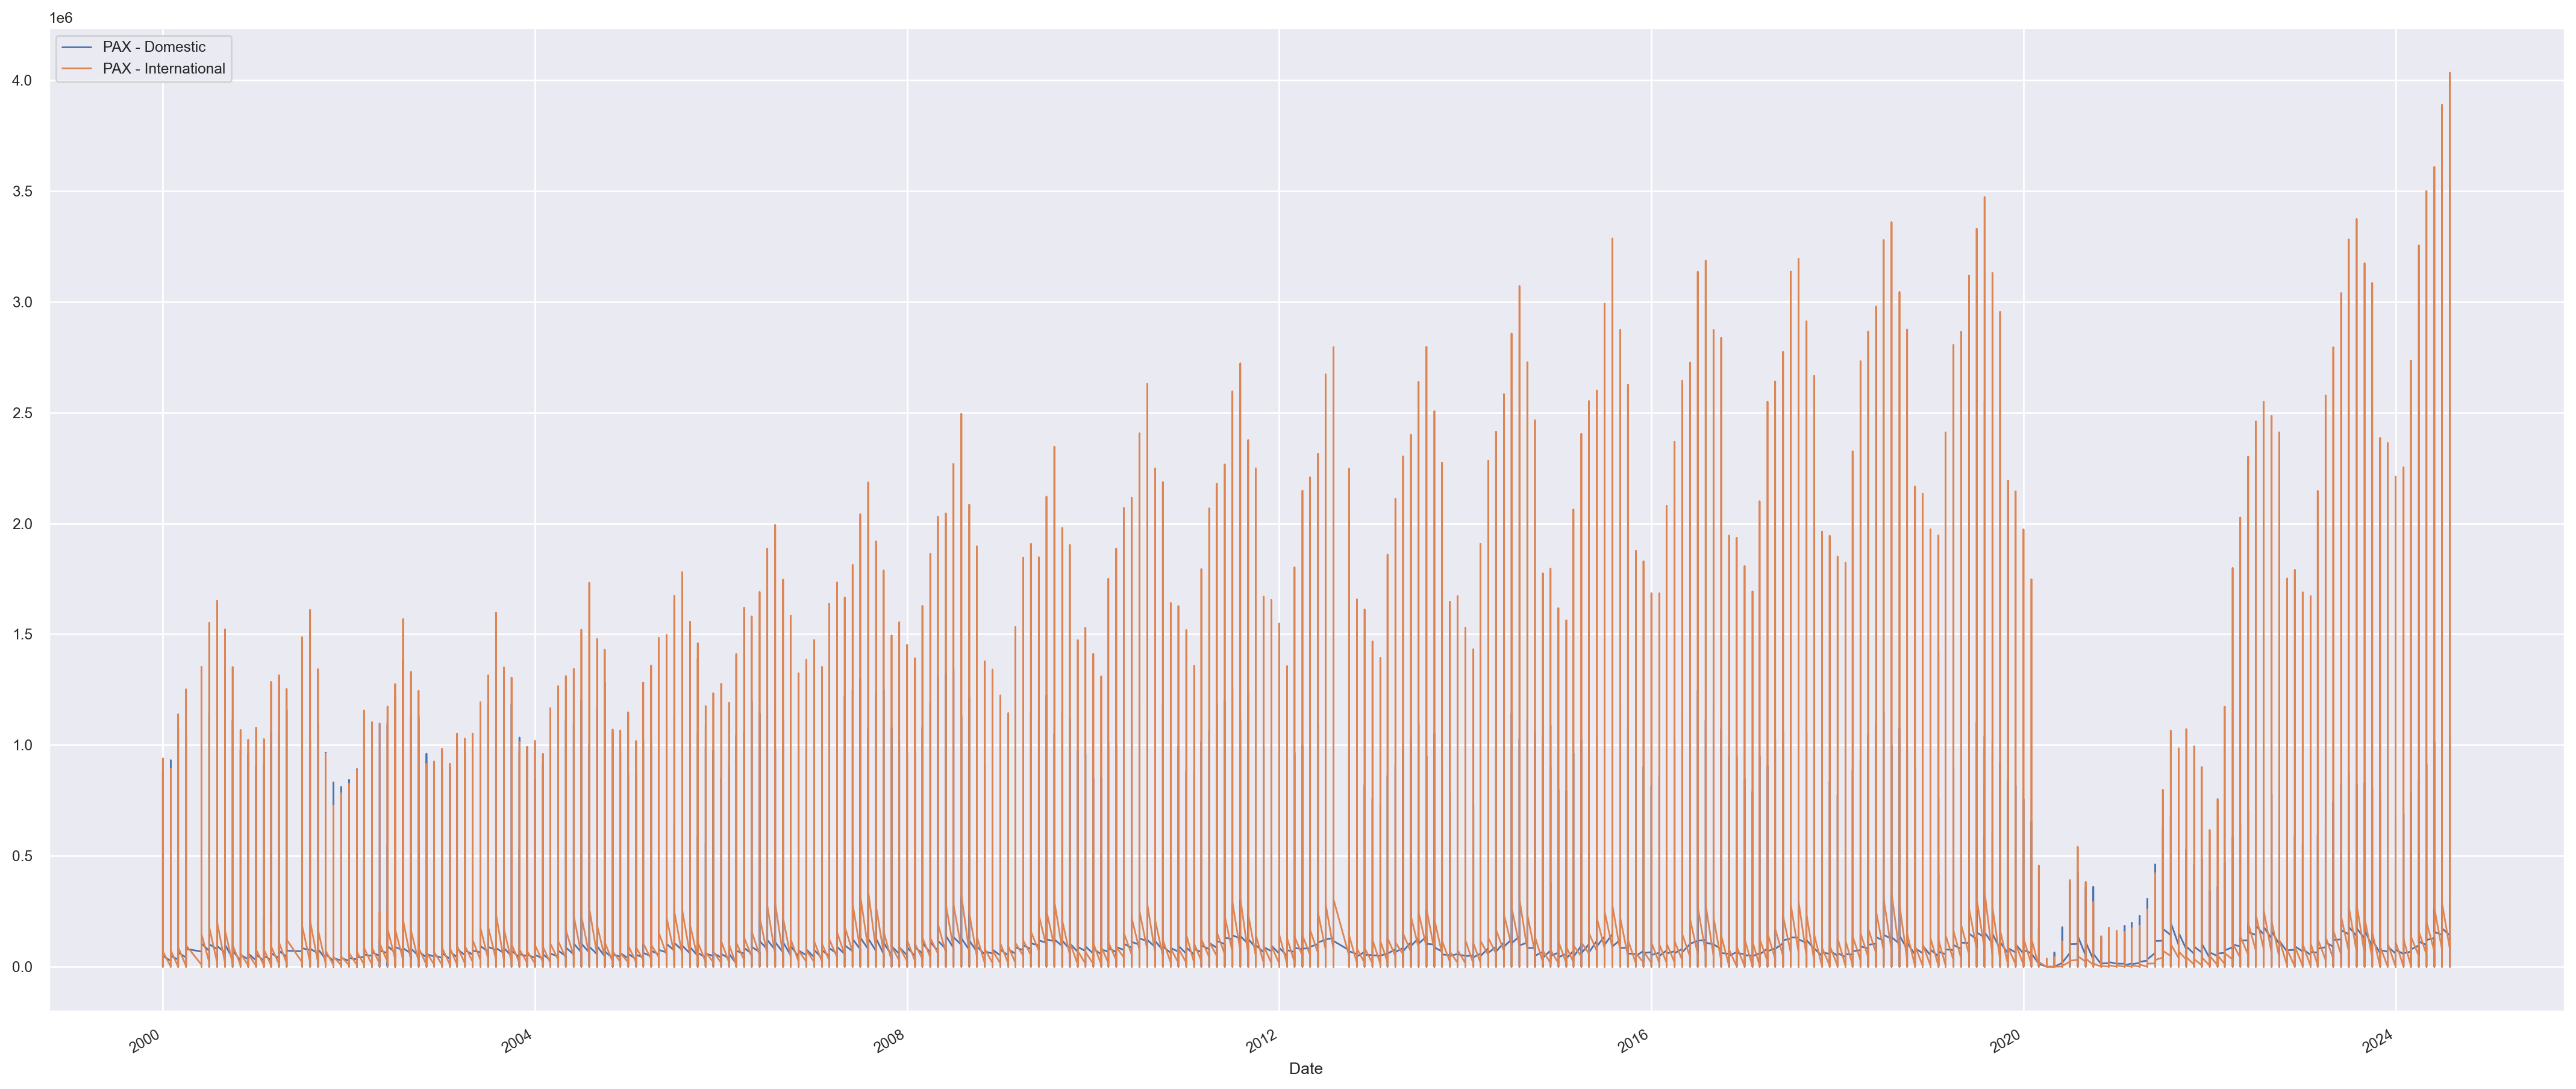

In [70]:

df_t.plot(y = ['PAX - Domestic', 'PAX - International'],
        figsize=(24, 12), linewidth=1);

In [67]:
# save the test dataframe as CSV
df_t.to_csv('datasets/final/df_fin.csv', encoding='utf-8', index=False)